In [1]:
# Normal imports for everybody
from keras.models import Model
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Input, Dropout
from keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

Using TensorFlow backend.


In [2]:
t=time.time()
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')
print(time.time()-t)
print(np.shape(X),np.shape(Y))

106.27912425994873
(24571, 5000) (24571, 500)


In [8]:
X=np.reshape(X,(-1,1000,5))

plt.plot(X[:,:,4])
plt.show()
X=X[:,:,:4]

eps=1e-15

X=X*(X>0)
X=np.log10(X+eps)

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(4):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]

#X=np.reshape(X,(-1,1000*4))

Y=np.log10(Y*1e20)

#Min_Max Scaling of Y
y_min=np.min(Y)
Y=Y-y_min
y_max=np.max(Y)
Y=Y/y_max

Y=np.reshape(Y,(-1,500,1))

ValueError: cannot reshape array of size 65536000 into shape (1000,5)

In [4]:
Y=np.reshape(Y,(-1,500))

In [9]:
X=X[:16384,:]
Y=Y[:16384,:]

In [17]:
latent_dim=16
batch_size=256

model = Sequential()

model.add(Bidirectional(LSTM(latent_dim, return_sequences = True), input_shape=(1000,4)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(latent_dim)))
model.add(Dropout(0.2))

model.add(Dense(500, activation='sigmoid'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 1000, 32)          2688      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               16500     
Total params: 25,460
Trainable params: 25,460
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(X, Y, batch_size=batch_size, epochs=3, validation_split=0.15, shuffle=False) #callbacks=[keras.callbacks.TerminateOnNaN()]
model.summary()

Train on 13926 samples, validate on 2458 samples
Epoch 1/3
13926/13926 [==============================] - 293s 21ms/step - loss: 0.0624 - val_loss: 0.0112
Epoch 2/3
13926/13926 [==============================] - 312s 22ms/step - loss: 0.0089 - val_loss: 0.0063
Epoch 3/3
13926/13926 [==============================] - 313s 22ms/step - loss: 0.0067 - val_loss: 0.0048
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 1000, 32)          2688      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000, 32)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 32)                6272      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_______________________________________

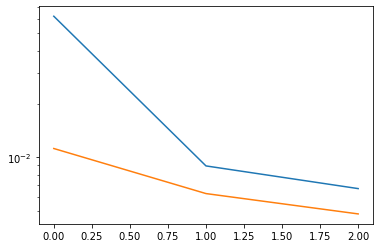

In [19]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

In [20]:
import scipy.ndimage.filters as sp
from scipy.special import softmax
import importlib
import bolsig
importlib.reload(bolsig)
from bolsig import bolsig

In [21]:
n=10

In [25]:
y_hat=model.predict(X[:n,:])
#y_hat=sp.gaussian_filter1d(y_hat,20)

In [26]:
X_new=np.copy(np.reshape(X,(-1,1000,4))[:n,:,:])

|(1000, 4)


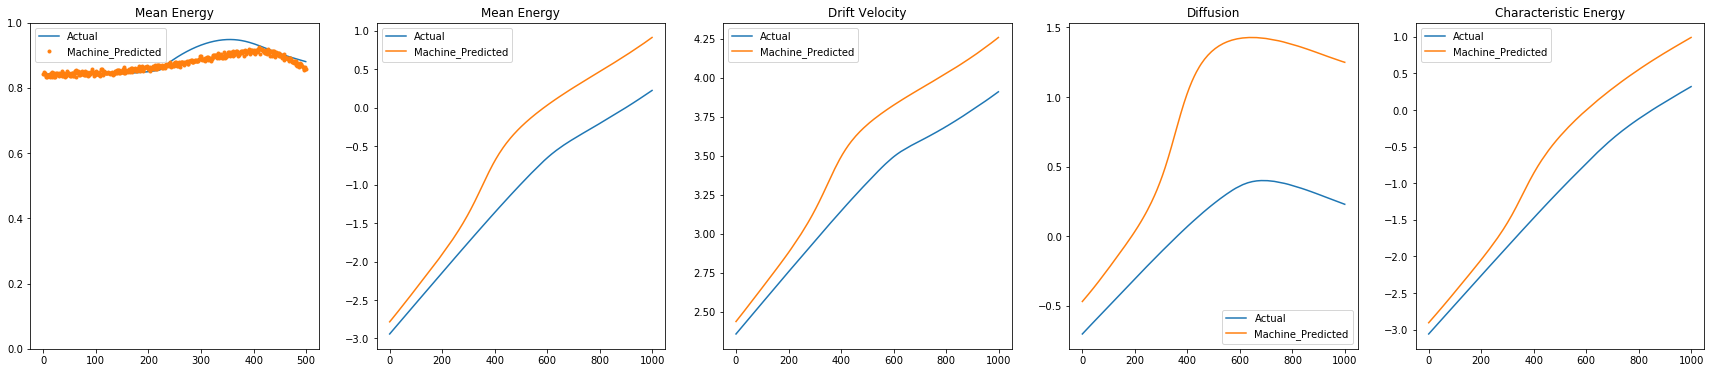

|(1000, 4)


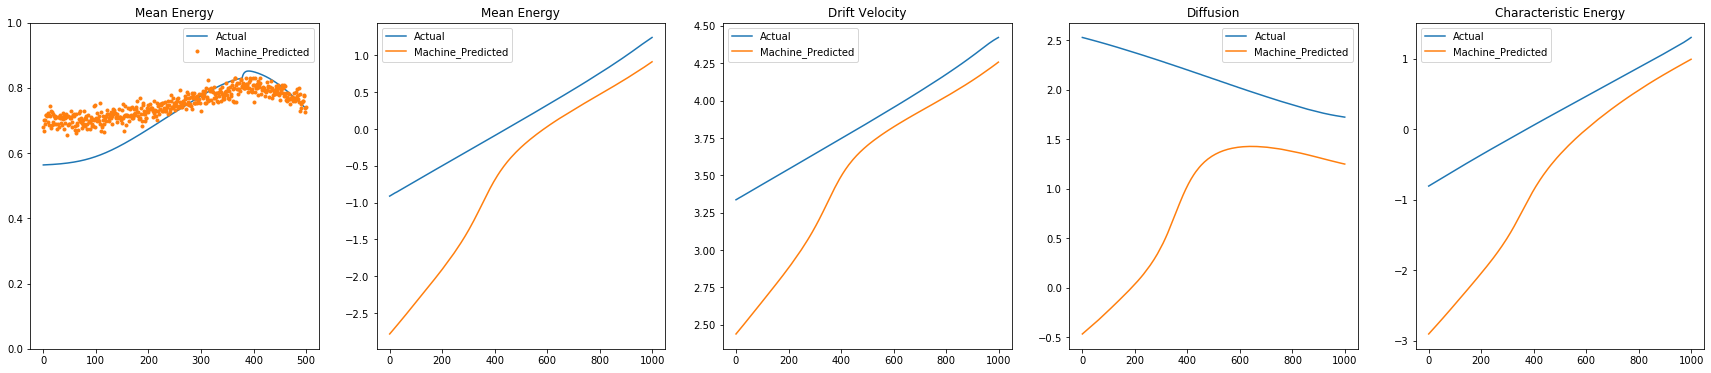

|(1000, 4)


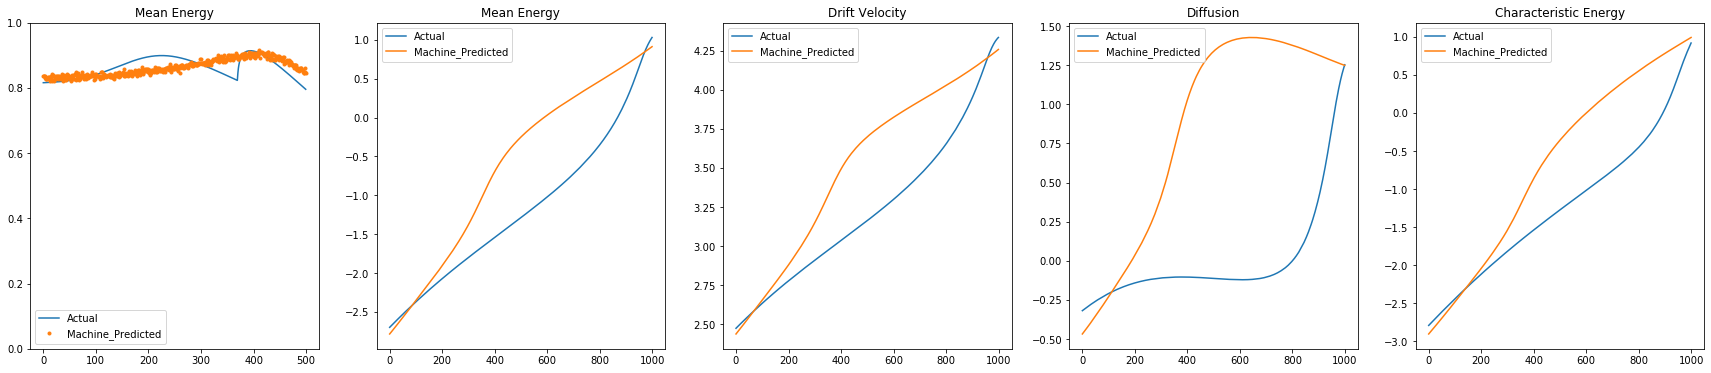

|(1000, 4)


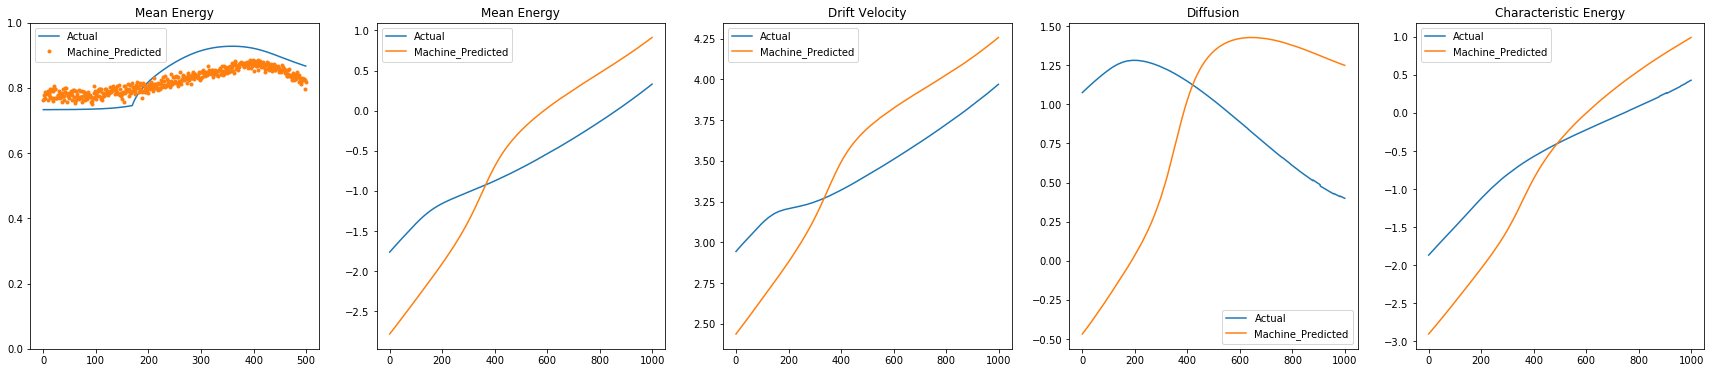

|(1000, 4)


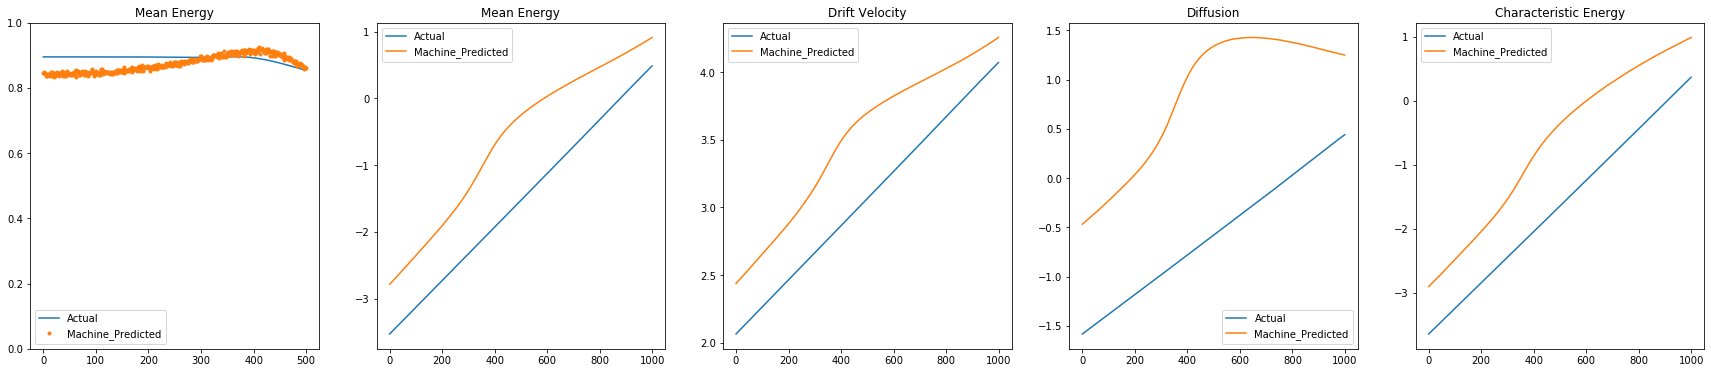

|(1000, 4)


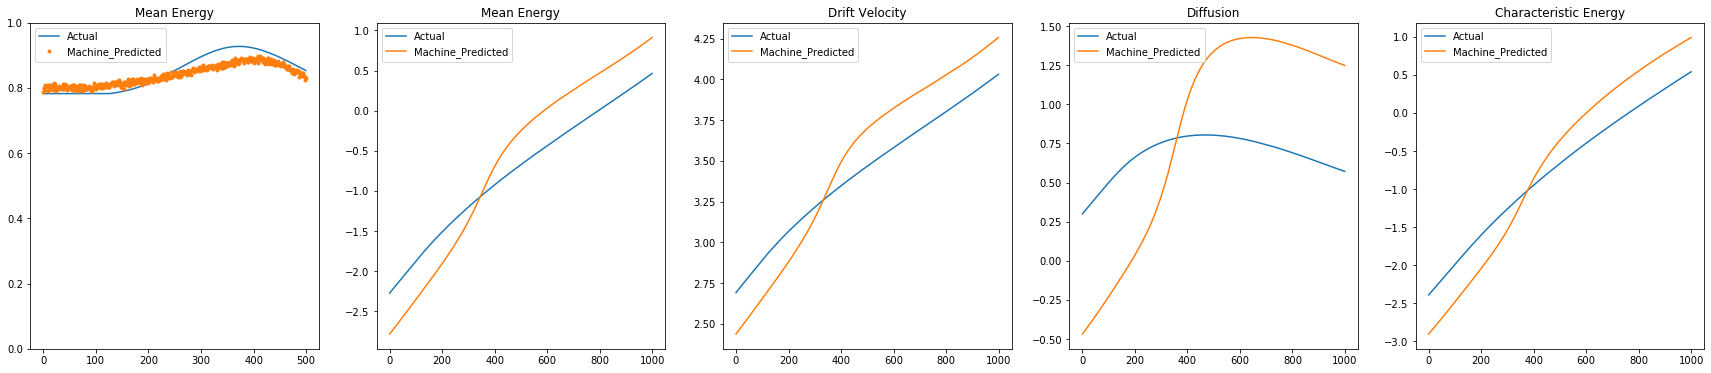

|(1000, 4)


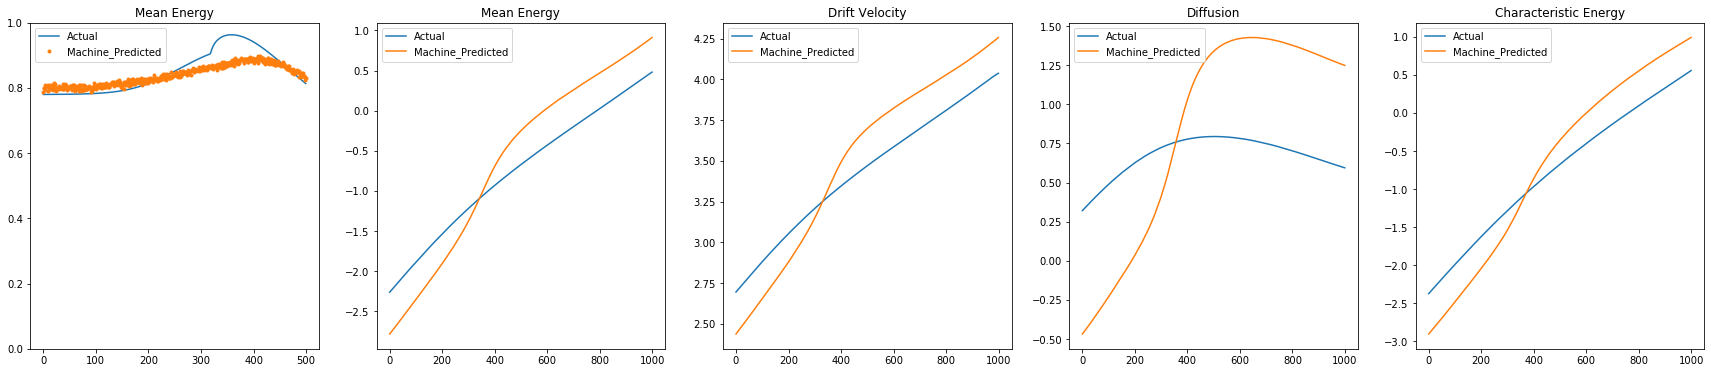

|(1000, 4)


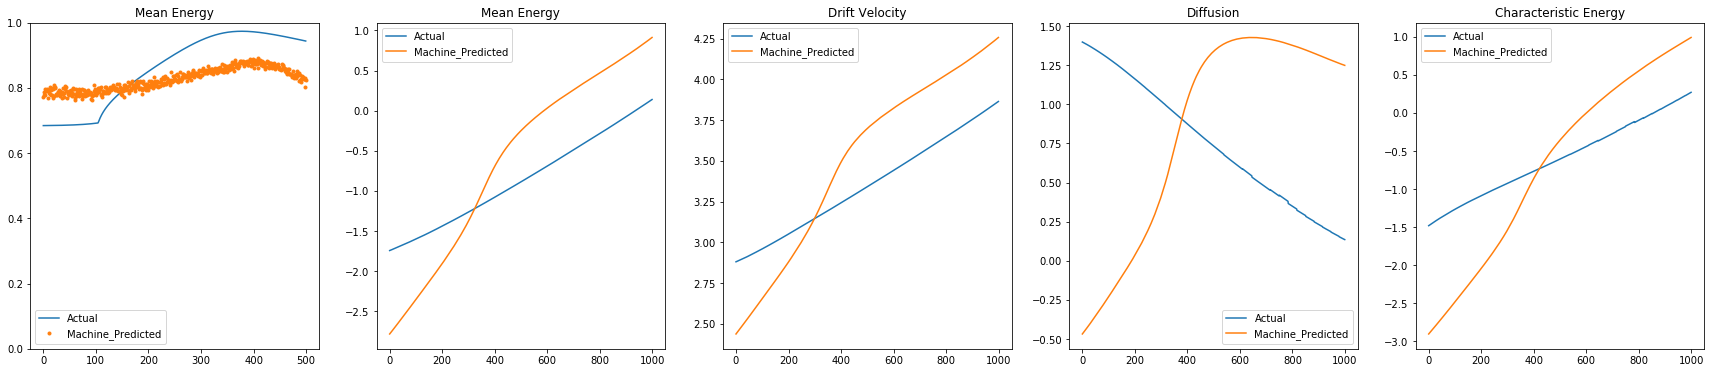

|(1000, 4)


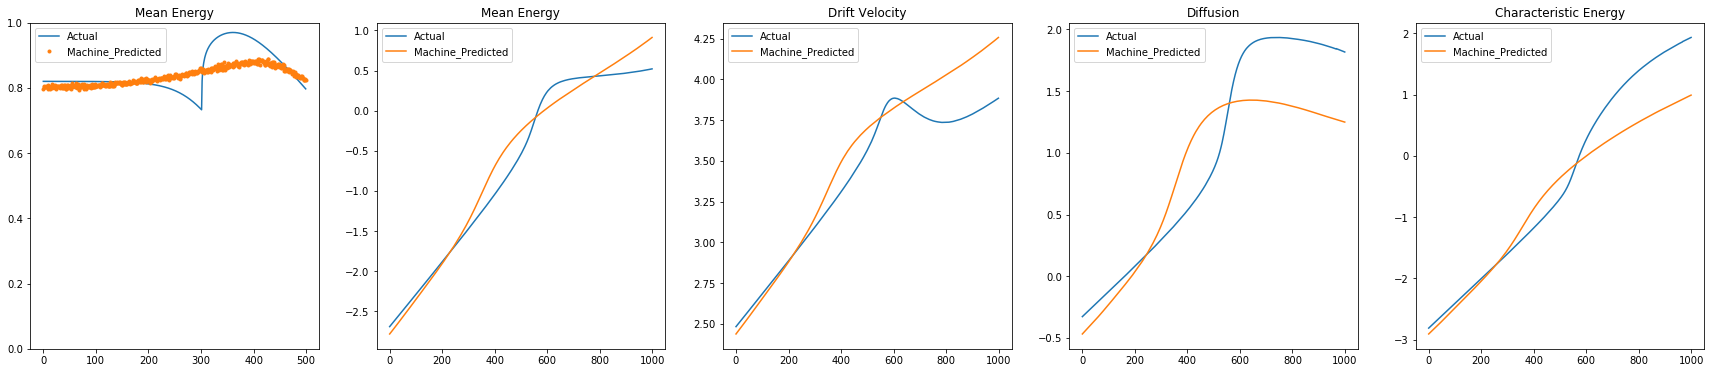

|(1000, 4)


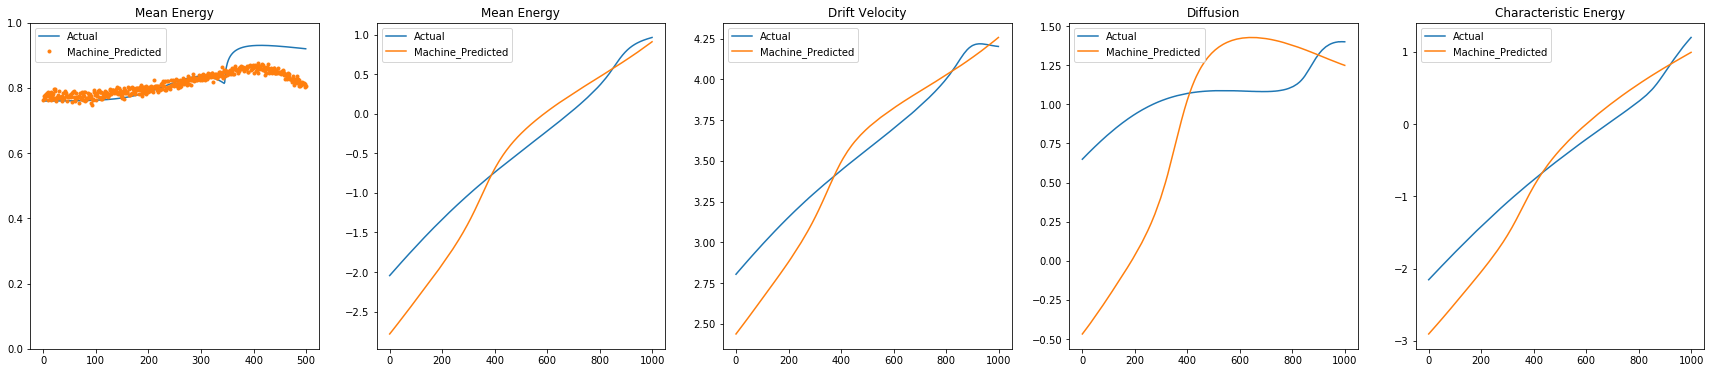

10.63657546043396


In [27]:
#Inverting normalisation of Predicted Y
y_pred=10**((y_hat*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(n):
    #plt.loglog(E,y_hat[i,:])
    bolsig.Input(E,y_pred[i,:])
    bolsig.ex(grid=100,n=1000,E_min=1e-3,E_max=10) #n cannot be more than 1000
    #bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Denormalisation of X_new to match trans
    for j in range(4):
        X_new[i,:,j]=X_new[i,:,j]*x_std[j]+x_mean[j]
        
    fig, ax = plt.subplots(1, 5, figsize=(30,6))
    title=['Cross Section','Mean Energy',
           'Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].plot(Y[i,:])
    ax[0].plot(y_hat[i,:],'.')
    ax[0].legend(['Actual','Machine_Predicted'])
    ax[0].set_title(title[1])
    ax[0].set_ylim((0,1))
    for j in range(4):
        ax[j+1].plot(np.reshape(X_new[i,:],(1000,4))[:,j])
        ax[j+1].plot(trans[:,j])
        ax[j+1].legend(['Actual','Machine_Predicted'])
        ax[j+1].set_title(title[j+1])
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)